In [8]:
import numpy
import random
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (16.0, 10.0)

In [9]:
def test_model(rew_dist,r_success,r_failure,no_trial,switching_trials):
    
    #Input arguments
    #rew_dist - 2D array, where rew_dist(i,j) is the probability of getting a reward=r_success by 
    #choosing action j in context i
    #r_success - Amount of reward given to the agent if it chooses the correct action
    #r_failure - Amount of reward given to the agent if it chooses the non-correct action
    #no_trial - Number of trials for the agent in each session
    #switching_trials - Trials at which the context switches
    
    #Number of sessions (Different Independent runs)
    no_session=50
    
    #2D array of size no_session*no_trial where prob_con1(i,j) is the probability of context 1 estimated
    #by the agent at session i and trial j
    prob_con1=[]
    
    # Number of past events taken into account to update the model
    history=5
    
    #2D array of size no_session*no_trial where correct_choice(i,j) indicates if the agent chose the correct
    #action at session i and trial j
    correct_choice=[]
    
    #Exploration factor- With a probability=exploration_factor, I choose any action with equal probability
    expl_factor=0.1
    
    #Iterate over no_session
    for i in range(0,no_session):
        
        #Current context of the environment
        actual_context=0
        
        #Temporary holder for the probability of context 1 estimated by the agent to be added to the prob_con1 
        #variable after each session
        prob_con1_temp=[]

        #Probability of getting reward r1 when choosing a1 being in estimated context c1, i.e. Module c1
        prob_a1_r1_c1=[]
        
        #Probability of getting reward r1 when choosing a1 being in estimated context c2, i.e. Module c2
        prob_a1_r1_c2=[]
        
        #2D array of size 2*2 where no_past_choices(i,j) refers to the number of times the agent has chosen 
        #action j when in estimated context i, i.e Module i. Note:Initially set as 1 to match this with the 
        #est_rew_dis(Avoid 0/0 case)
        no_past_choices=numpy.ones([2,2])
        
        #Estimated Reward Distribution- 2D array of size 2*2 where no_past_choices(i,j) refers to probability
        #of the agent getting a reward r=r_success when it takes action j in module i
        est_rew_dist=0.5*numpy.ones([2,2])
        
        #Temporary holder for the indicator of the correct choice made by the agent to be added to the 
        #correct_choice variable after each session
        correct_choice_temp=[]
        
        #[p0,p1], where pi is the probability of selecting module i
        prob_module_sel=[0.5,0.5]
        
        #Iterate over the number of trials
        for j in range(0,no_trial):
            
            #Switch the environmental context at the indicated trials
            if j in switching_trials:
                actual_context=1-actual_context
                
            #Selected module. Note: Cannot just use argmax since it just gives the first in case the probabilities
            #are equal
            mod_sel=random.choice([i for i, x in enumerate(prob_module_sel) if x == max(prob_module_sel)])
            
            #Action chosen. Note: Cannot just use argmax for the same reason above.
            a=random.choice([i for i, x in enumerate(est_rew_dist[mod_sel,:]) if x == max(est_rew_dist[mod_sel,:])])
            
            #Choosing random action with probability expl_factor
            if random.random()<expl_factor:
                a=random.randint(0,1)
            
            #Giving reward with the probability indicated by rew_dist
            if random.random()<rew_dist[actual_context,a]:
                r=r_success
            else:
                r=r_failure
            
            #Determining the correct action for the trial
            correct_choice_trial=numpy.argmax(rew_dist[actual_context,:])
            
            #Storing 1 if the correct action is chosen
            correct_choice_temp.append(int(a==correct_choice_trial))
            
            #Update the estimated probability of reward
            est_rew_dist[mod_sel,a]=((est_rew_dist[mod_sel,a]*no_past_choices[mod_sel,a])+r)/(no_past_choices[mod_sel,a]+1)
            
            #Update the choice based on the action chosen and module selected
            no_past_choices[mod_sel,a]=no_past_choices[mod_sel,a]+1
            
            #est_rew_dist gives the probability of getting r=r_success. Thus if r=r_failure, we update the probability
            #term as 1-est_rew_dist
            if r==r_success:
                prob_a1_r1_c1.append(est_rew_dist[0,a])
                prob_a1_r1_c2.append(est_rew_dist[1,a])
            else:
                prob_a1_r1_c1.append(1-est_rew_dist[0,a])
                prob_a1_r1_c2.append(1-est_rew_dist[1,a])
            
            #Using the rule derived in the model to get the probability of module being i given the action and reward 
            #history
            prob_mod1=numpy.prod(prob_a1_r1_c1[max(0,(len(prob_a1_r1_c1)-history)):])/(numpy.prod(prob_a1_r1_c1[max(0,(len(prob_a1_r1_c1)-history)):])+numpy.prod(prob_a1_r1_c2[max(0,(len(prob_a1_r1_c2)-history)):]))
            
            #Updating the probability of module by storing the calculated probability and the other module as 
            #1-calculated probability
            prob_module_sel=[prob_mod1,1-prob_mod1]
            prob_con1_temp.append(prob_mod1)
        prob_con1.append(prob_con1_temp)
        correct_choice.append(correct_choice_temp)
    prob_con1=numpy.array(prob_con1)
    
    #This step ensures that the module assigned to the contexts are matched across sessions. This is needed as the
    #module assignment to the context is random and unless we match them, the mean won't give any meaningful result
    prob_con1[numpy.mean(prob_con1[:,switching_trials[0]:((2*switching_trials[0])+1)],axis=1)<0.5,:]=1-prob_con1[numpy.mean(prob_con1[:,switching_trials[0]:((2*switching_trials[0])+1)],axis=1)<0.5,:]
    return([prob_con1,correct_choice])

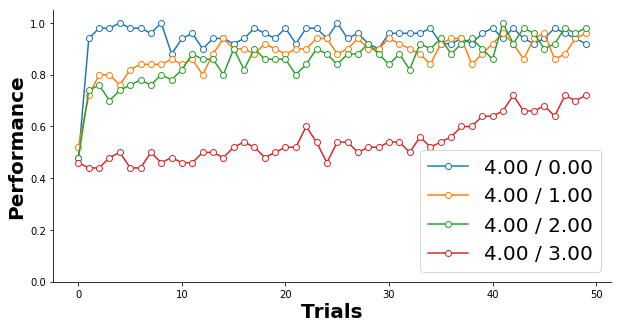

In [10]:
# Number of trials
n_trial  = 110

# Trials after which a switch is made
switches = [50]

# Reward for bad choice, reward for goo choice
r_min, r_max = 0, 4

# reward probabilities
p=numpy.array([[1,0],[0,1]])


fig = plt.figure(figsize=(10,5))
ax = plt.subplot(1,1,1)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
# Outward ticks
ax.tick_params(axis='x', direction='out')
ax.tick_params(axis='y', direction='out')


colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
          "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

for i,r_min in enumerate([0,1,2,3]):
    p = numpy.array(p)

    pc1, choices = test_model(p, r_max, r_min, n_trial, switches)
    choices = numpy.array(choices)
    label = "%.2f / %.2f" % (r_max, r_min)
    Y = numpy.mean(choices[:,:50],axis=0)
    X = numpy.arange(len(Y))
    color = colors[i]
    ax.plot(X, Y, linewidth=1.5, label=label, marker='o', color=color,
            markerfacecolor="w", markeredgecolor=color, markeredgewidth=1.0)

ax.set_xlabel('Trials',fontsize=20,fontweight='bold')
ax.set_ylabel('Performance',fontsize=20,fontweight='bold')
#ax.set_title('Effect of Reward Magnitude')
ax.set_ylim([0,1.05])
ax.legend(loc="lower right", frameon=True,fontsize=20)
#plt.savefig('fig1.png')
plt.show()

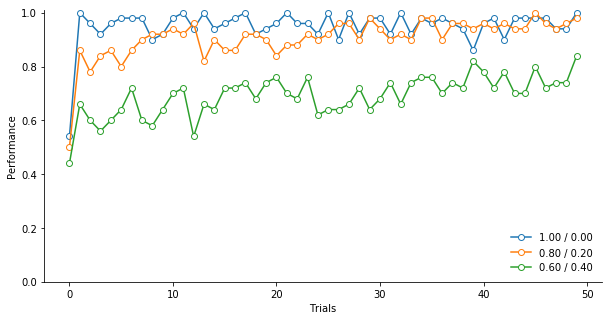

In [11]:
# Number of trials
n_trial  = 100

# Trials after which a switch is made
switches = [99]

# Reward for bad choice, reward for goo choice
r_min, r_max = 0, 1

# reward probabilities
probabilities = [[[1.00, 0.00], [0.00, 1.00]],
                 [[0.80, 0.20], [0.20, 0.80]],
                 [[0.60, 0.40], [0.60, 0.40]]]


fig = plt.figure(figsize=(10,5))
ax = plt.subplot(1,1,1)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
# Outward ticks
ax.tick_params(axis='x', direction='out')
ax.tick_params(axis='y', direction='out')


colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
          "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

for i,p in enumerate(probabilities):
    p = numpy.array(p)

    pc1, choices = test_model(p, r_max, r_min, n_trial, switches)
    choices = numpy.array(choices)
    label = "%.2f / %.2f" % (p[0][0], p[0][1])
    Y = numpy.mean(choices[:,:50],axis=0)
    X = numpy.arange(len(Y))
    color = colors[i]
    ax.plot(X, Y, linewidth=1.5, label=label, marker='o', color=color,
            markerfacecolor="w", markeredgecolor=color, markeredgewidth=1.0)

ax.set_xlabel('Trials')
ax.set_ylabel('Performance')
ax.set_ylim([0,1.01])
#ax.set_title('Effect of Reward Probability')
ax.legend(loc="lower right", frameon=False, fontsize=10)
#plt.savefig('fig2.pdf')
plt.show()

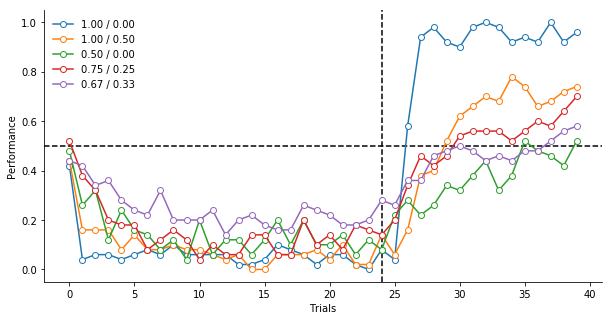

In [12]:
# Number of trials
n_trial  = 50

# Trial after which a switch is made
no_switch = 24

# Reward for bad choice, reward for goo choice
r_min, r_max = 0, 1

# reward probabilities
probabilities = [[[1.00, 0.00], [0.00, 1.00]],
                 [[1.00, 0.50], [0.50, 1.00]],
                 [[0.50, 0.00], [0.00, 0.50]],
                 [[0.75, 0.25], [0.25, 0.75]],
                 [[0.67, 0.33], [0.33, 0.67]]]


fig = plt.figure(figsize=(10,5))
ax = plt.subplot(1,1,1)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
# Outward ticks
ax.tick_params(axis='x', direction='out')
ax.tick_params(axis='y', direction='out')


colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
          "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

for i,p in enumerate(probabilities):
    p = numpy.array(p)

    pc1, choices = test_model(p, r_max, r_min, n_trial, [no_switch])
    choices = numpy.array(choices)
    choices[:,0:24] = 1 - choices[:,0:24]
    label = "%.2f / %.2f" % (p[0][0], p[0][1])
    Y = numpy.mean(choices[:,0:40],axis=0)
    X = numpy.arange(len(Y))
    color = colors[i]
    ax.plot(X, Y, linewidth=1.5, label=label, marker='o', color=color,
            markerfacecolor="w", markeredgecolor=color, markeredgewidth=1.0)

ax.axvline(no_switch, color='k', linestyle="--", zorder=-10)
ax.axhline(0.5, color='k', linestyle="--", zorder=-10)
ax.set_xlabel('Trials')
ax.set_ylabel('Performance')
#ax.set_title('Unprofitable side                                                        Profitable Side')
ax.legend(loc="upper left", frameon=False, fontsize=10)
#plt.savefig('fig3.pdf')
plt.show()

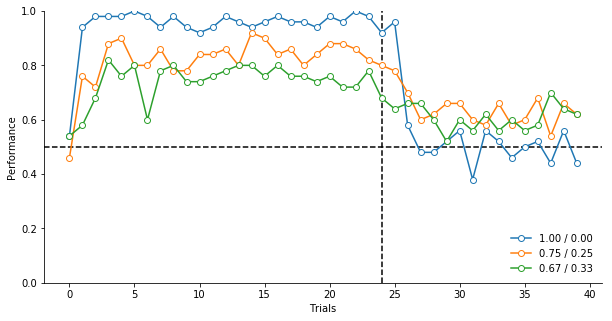

In [13]:
# Number of trials
n_trial  = 50

# Trials after which a switch is made
switches = [24]

# Reward for bad choice, reward for goo choice
r_min, r_max = 0, 1

# reward probabilities
probabilities = [[[1.00, 0.00], [0.00, 0.00]],
                 [[0.75, 0.25], [0.00, 0.00]],
                 [[0.67, 0.33], [0.00, 0.00]]]


fig = plt.figure(figsize=(10,5))
ax = plt.subplot(1,1,1)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
# Outward ticks
ax.tick_params(axis='x', direction='out')
ax.tick_params(axis='y', direction='out')


colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
          "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

for i,p in enumerate(probabilities):
    p = numpy.array(p)

    pc1, choices = test_model(p, r_max, r_min, n_trial, switches)
    choices = numpy.array(choices)
    label = "%.2f / %.2f" % (p[0][0], p[0][1])
    Y = numpy.mean(choices[:,:40],axis=0)
    X = numpy.arange(len(Y))
    color = colors[i]
    ax.plot(X, Y, linewidth=1.5, label=label, marker='o', color=color,
            markerfacecolor="w", markeredgecolor=color, markeredgewidth=1.0)
ax.axvline(no_switch, color='k', linestyle="--", zorder=-10)
ax.axhline(0.5, color='k', linestyle="--", zorder=-10)
axes = plt.gca()
axes.set_ylim([0,1])
ax.set_xlabel('Trials')
ax.set_ylabel('Performance')
#ax.set_title('Effect of Reward Probability')
ax.legend(loc="lower right", frameon=False, fontsize=10)
#plt.savefig('fig6.pdf')
plt.show()

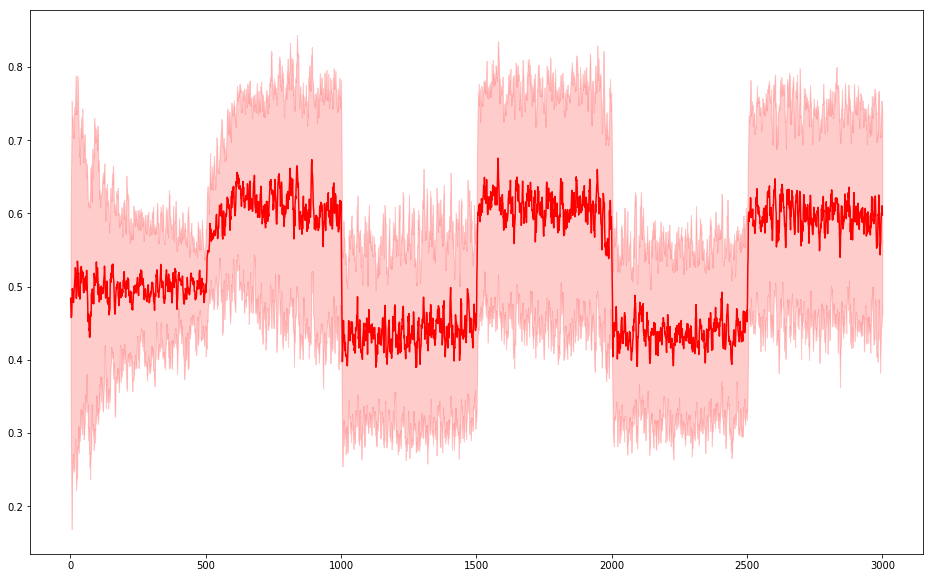

In [18]:
no_trial=3000
switches=[500,1000,1500,2000,2500]
r_max=1
r_min=0
rp=0.35
ch=[]
rew_dist=numpy.array([[1-rp,rp],[rp,1-rp]])
[pc1,choices]=test_model(rew_dist,r_max,r_min,no_trial, switches)
pc1=numpy.array(pc1)
me=pc1.mean(axis=0)
st=pc1.std(axis=0)
plt.plot(range(1,3001),me,'r')
plt.fill_between(range(1,3001),me-st,me+st,alpha=0.2,edgecolor='r',facecolor='r')
